In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("../")
device="cuda:0"
from tqdm import tqdm_notebook as tqdm

In [2]:
from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [3]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/chair/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook12/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)

In [4]:
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)

In [5]:
os.makedirs(args.model_path, exist_ok=True)
gaussians = GaussianModel(3)#.to(device="cuda")
scene = Scene(dataset, gaussians, shuffle=True)

#gaussians.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [6]:
gaussians._xyz.shape, gaussians.max_radii2D.shape

(torch.Size([100000, 3]), torch.Size([100000]))

In [33]:
gaussians.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)

In [8]:
gaussians._xyz.shape, gaussians.max_radii2D.shape

(torch.Size([278573, 3]), torch.Size([278573]))

In [9]:
#gaussians.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2/chkpnt1.pth")[0], opt)

In [10]:
# gaussians.max_radii2D = torch.ones(len(gaussians._xyz), dtype=torch.float32, device=device)

In [11]:
gaussians._xyz.shape, gaussians.max_radii2D.shape

(torch.Size([278573, 3]), torch.Size([278573]))

In [12]:


bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)

In [13]:
viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))


In [14]:

render_pkg = render(viewpoint_cam, gaussians, pipe, background)
# image, viewspace_point_tensor, visibility_filter, radii, depth= render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["depth"]


In [15]:
#gaussians.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2/chkpnt1.pth")[0], opt)

In [16]:
image, viewspace_point_tensor, visibility_filter, radii, depth= render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["depth"]

In [17]:
image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<_RasterizeGaussiansBackward>)

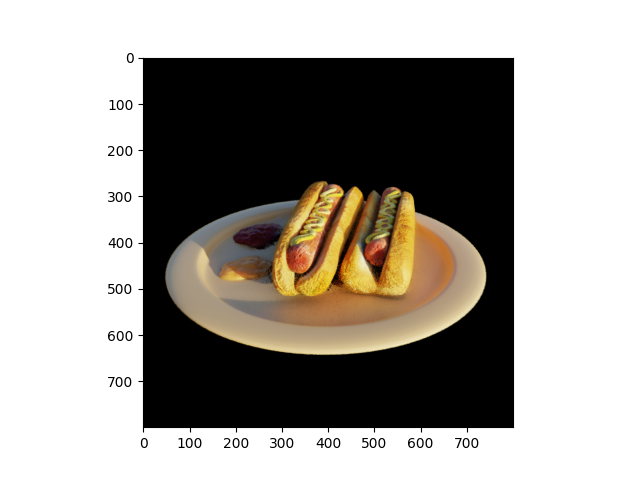

In [18]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)

# Clip values to be in the range [0, 1]
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

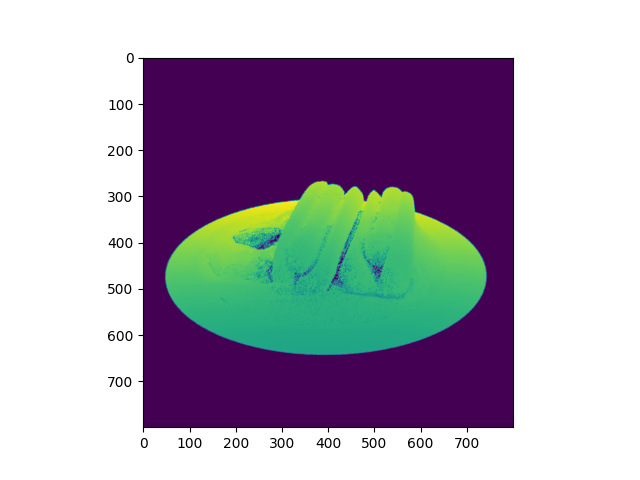

In [19]:
depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.show()

In [20]:
for attr in ['_xyz', '_features_dc', '_features_rest', '_scaling', '_rotation', '_opacity', 'max_radii2D', 'xyz_gradient_accum', 'denom']:
    print(getattr(gaussians, attr).shape)


torch.Size([278573, 3])
torch.Size([278573, 1, 3])
torch.Size([278573, 15, 3])
torch.Size([278573, 3])
torch.Size([278573, 4])
torch.Size([278573, 1])
torch.Size([278573])
torch.Size([278573, 1])
torch.Size([278573, 1])


In [21]:
os.makedirs(args.model_path, exist_ok=True)
gaussians_test = GaussianModel(3)#.to(device="cuda")
scene_test = Scene(dataset, gaussians_test, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [199]:
gaussians.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)
for attr in ['_xyz', '_features_dc', '_features_rest', '_scaling', '_rotation', '_opacity', 'max_radii2D', 'xyz_gradient_accum', 'denom']:
    setattr(gaussians_test, attr, getattr(gaussians, attr))#.detach().clone())

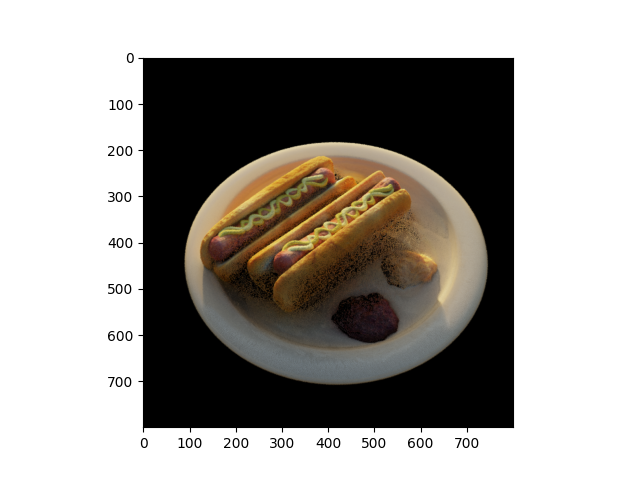

In [200]:
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_test = render(viewpoint_cam, gaussians_test, pipe, background)
image, depth= render_pkg_test["render"], render_pkg_test["depth"]
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)

# Clip values to be in the range [0, 1]
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [201]:
# Try to minimize TV loss on depth
def tv_loss(img):
    return 0.5 * (torch.abs(img[..., 1:, :] - img[..., :-1, :]).mean() +
                  torch.abs(img[..., :, 1:] - img[..., :, :-1]).mean())
def regress_to_mean_loss(depth):
    target = torch.mean(depth)
    return torch.mean(torch.square(torch.ones_like(depth) - depth))
    #return torch.mean(torch.square(target - depth))

gaussians_test._features_dc.requires_grad_ = False
gaussians_test._features_rest.requires_grad_ = False
gaussians_test._scaling.requires_grad_ = False
gaussians_test._rotation.requires_grad_ = False
gaussians_test._opacity.requires_grad_ = False
gaussians_test.max_radii2D.requires_grad_ = False

gaussians_test.training_setup(opt)

for param_group in gaussians_test.optimizer.param_groups:
    param_group['lr'] = 1e-3

losses = []


for step in tqdm(range(1001)):
    gaussians_test.optimizer.zero_grad(set_to_none = True)
    render_pkg_test = render(viewpoint_cam, gaussians_test, pipe, background)
    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene_test.getTrainCameras().copy()
        #print("viewpoint_stack:", viewpoint_stack)
    #viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

    image, depth= render_pkg_test["render"], render_pkg_test["depth"]
    # loss = tv_loss(depth)
    #loss = torch.mean(depth) + tv_loss(depth)
    loss = regress_to_mean_loss(depth)
    #print(loss)

    loss.backward()

    gaussians_test.optimizer.step()
    

    losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
    
    if step % 100 == 0:
        print(loss)

        # plt.figure()
        # plt.plot(losses)
        # plt.show()
        # plt.close()
        
        # depth_np = depth.detach().cpu().numpy()
        # plt.figure()
        # plt.imshow(depth_np)
        # plt.show()
        # plt.close()

/tmp/ipykernel_43026/1283390799.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(1001)):


  0%|          | 0/1001 [00:00<?, ?it/s]

tensor(1.4007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1786, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7474, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6473, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5530, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4621, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3815, device='cuda:0', grad_fn=<MeanBackward0>)


0.13645312190055847

In [28]:
losses

[-0.02894596755504608,
 -0.03344064578413963,
 -0.07354100048542023,
 -0.030478164553642273,
 -0.05091990903019905,
 -0.04358769580721855,
 -0.12077691406011581,
 -0.0720749944448471,
 -0.014643577858805656,
 -0.09700638055801392,
 -0.1296665072441101,
 -0.13190069794654846,
 -0.14298616349697113,
 -0.037359658628702164,
 -0.019450131803750992,
 -0.12287942320108414,
 -0.08710861206054688,
 -0.14125612378120422,
 -0.05102333426475525,
 -0.04765868932008743,
 -0.040865458548069,
 -0.05776212364435196,
 -0.05556153506040573,
 -0.18922647833824158,
 -0.047743216156959534,
 -0.02224571257829666,
 -0.03281284123659134,
 -0.03545374050736427,
 -0.16077299416065216,
 -0.021728727966547012,
 -0.13363276422023773,
 -0.12487762421369553,
 -0.023067791014909744,
 -0.04812337085604668,
 -0.14068520069122314,
 -0.14156422019004822,
 -0.04224373400211334,
 -0.09061814844608307,
 -0.1400815099477768,
 -0.03652679920196533,
 -0.109339639544487,
 -0.02393510937690735,
 -0.17166391015052795,
 -0.1552150

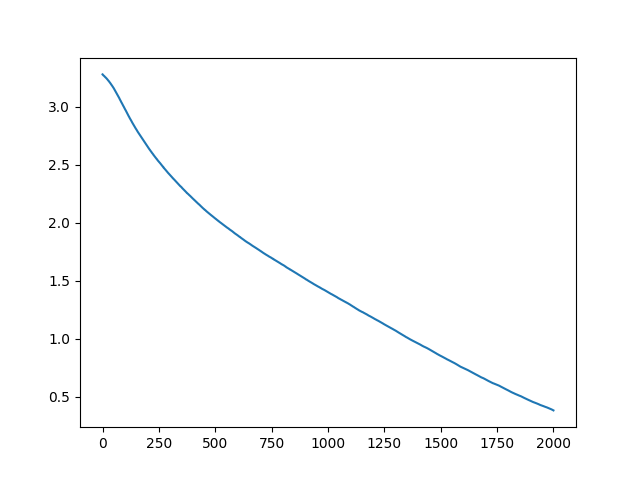

In [218]:
# plt.plot([x.cpu() for x in losses])
plt.figure()
plt.plot(losses)#np.stack([x.cpu().detach().numpy() for x in losses]))
plt.show()


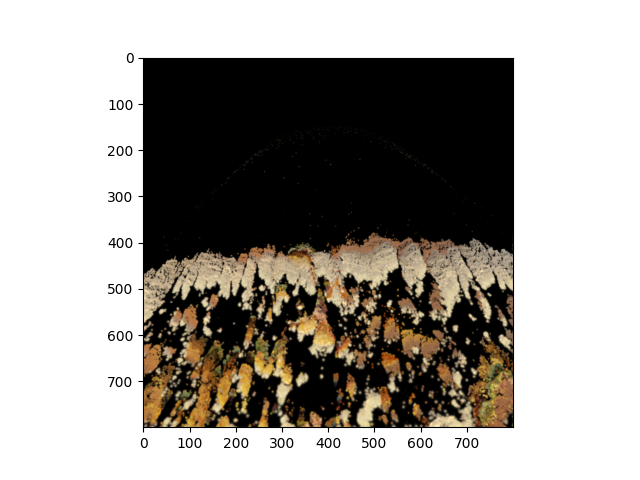

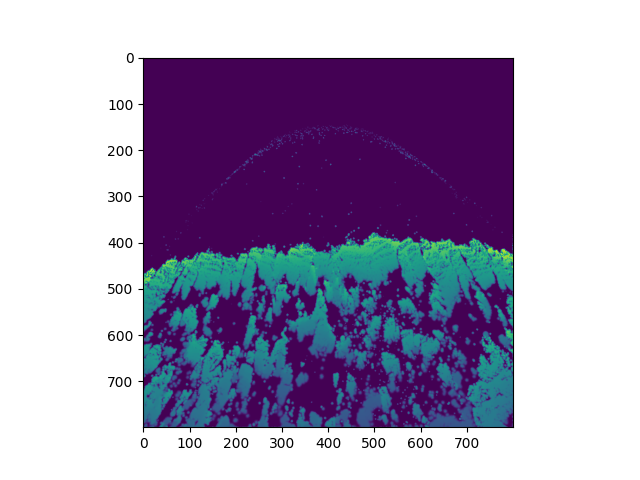

In [219]:

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.show()

In [150]:
depth_np[600,700], depth_np[0,0]

(0.0, 2.6602573)

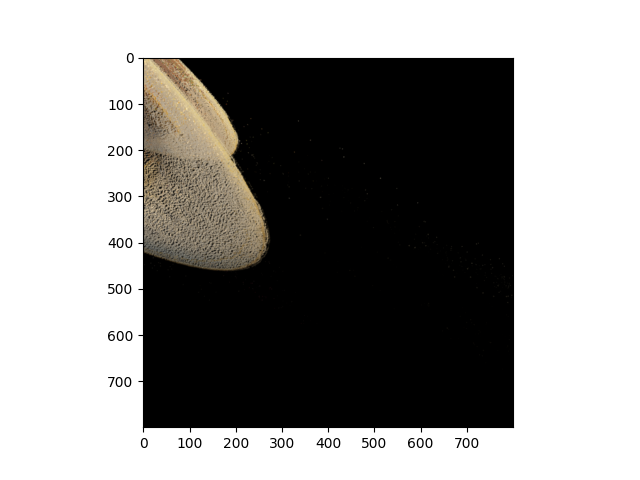

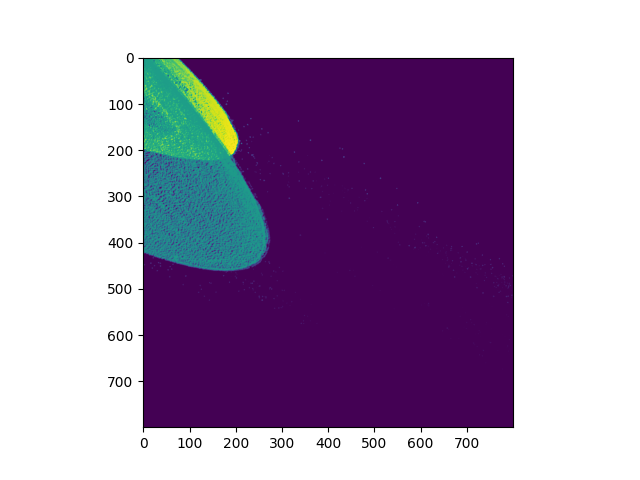

In [230]:
viewpoint_cam_novel = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_test = render(viewpoint_cam_novel, gaussians_test, pipe, background)
image, depth= render_pkg_test["render"], render_pkg_test["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.show()

# Now render a single cluster from lego and try to render them jointly